# Ranging Calculations in SpaceLink

This notebook demonstrates the ranging functions available in the SpaceLink library. Ranging is crucial for determining the distance and relative velocity of spacecraft and ground stations.

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

# Import ranging functions from SpaceLink
# Note: These could be imported directly from spacelink.core if they were added to core/__init__.py
from spacelink.core.ranging import (
    pn_sequence_range_ambiguity,
    chip_snr,
    power_fractions_sine,
    suppression_factor_sine,
    modulation_factor_sine,
    suppression_factor_bipolar,
    modulation_factor_bipolar
)

# Import unit conversion utilities
from spacelink.core.units import to_dBHz, Dimensionless

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

## PN Sequence Range Ambiguity

The range ambiguity is the maximum unambiguous range that can be measured with a given PN sequence. It depends on the sequence length and chip rate.

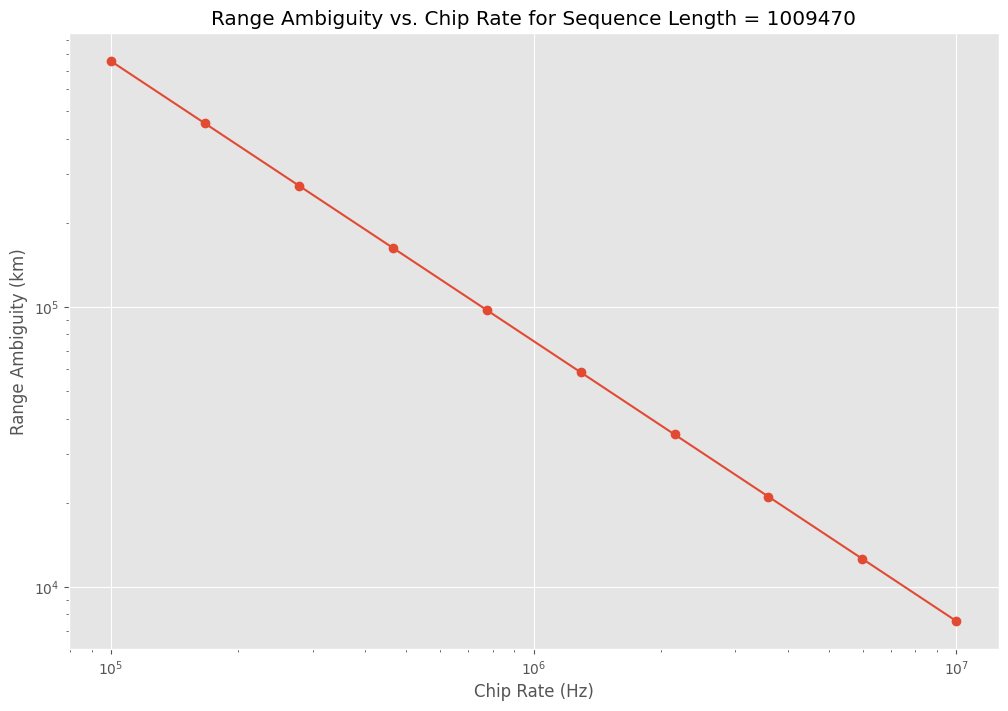

In [7]:
# Calculate range ambiguity for different chip rates
chip_rates = np.logspace(5, 7, 10) * u.Hz  # From 100 kHz to 10 MHz

ambiguities = [pn_sequence_range_ambiguity(rate).to(u.km) for rate in chip_rates]

plt.figure()
plt.loglog(chip_rates.value, [amb.value for amb in ambiguities], 'o-')
plt.xlabel('Chip Rate (Hz)')
plt.ylabel('Range Ambiguity (km)')
plt.title(f'Range Ambiguity vs. Chip Rate for Sequence Length = {sequence_length}')
plt.grid(True)
plt.show()

## Chip SNR Calculation

The chip SNR is a critical parameter for ranging performance. It depends on the chip rate and the ranging signal power to noise density ratio (PR/N0).

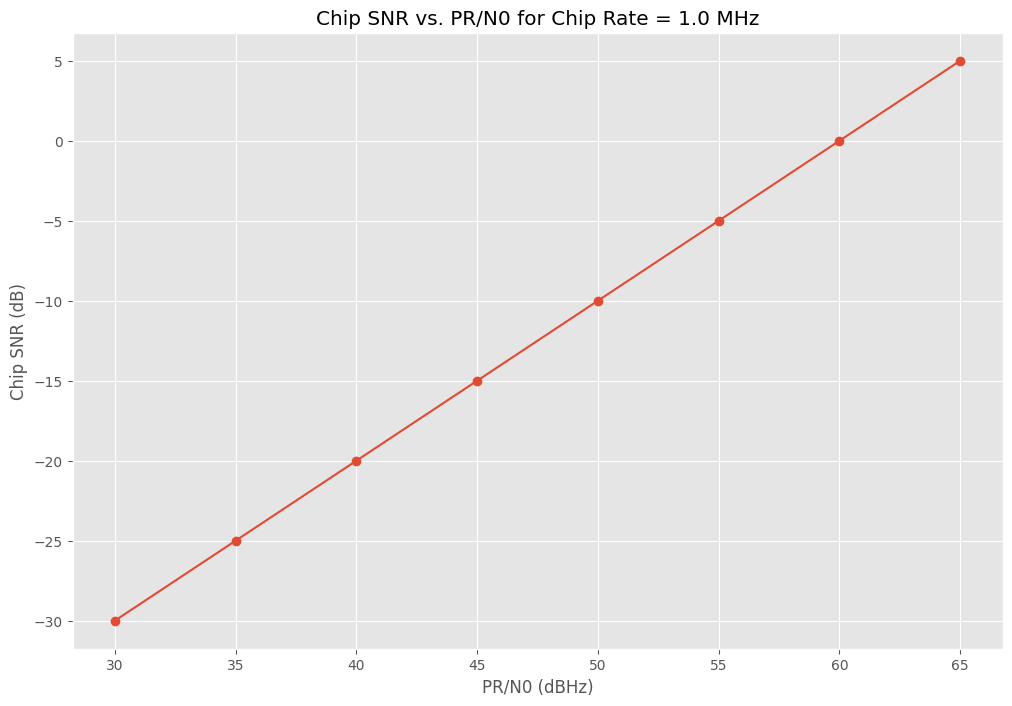

In [8]:
# Calculate chip SNR for different PR/N0 values
prn0_values = np.arange(30, 70, 5) * u.dBHz  # PR/N0 values from 30 to 65 dBHz
chip_rate = 1.0 * u.MHz  # 1 MHz chip rate

snr_values = [chip_snr(chip_rate, prn0) for prn0 in prn0_values]

plt.figure()
plt.plot(prn0_values.value, [snr.value for snr in snr_values], 'o-')
plt.xlabel('PR/N0 (dBHz)')
plt.ylabel('Chip SNR (dB)')
plt.title(f'Chip SNR vs. PR/N0 for Chip Rate = {chip_rate}')
plt.grid(True)
plt.show()

## Power Fractions in Modulated Signals

When a carrier is modulated with both ranging and command/data signals, the power is distributed among the carrier, ranging sidebands, and data sidebands. Let's explore how these power fractions vary with modulation indices.

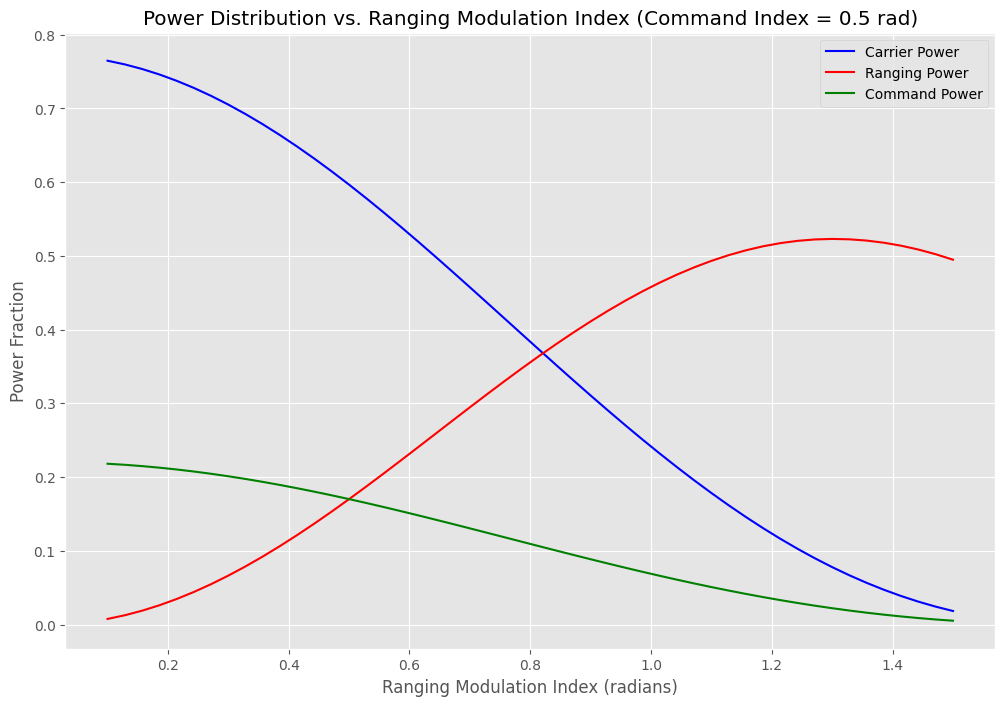

In [11]:
# Calculate power fractions for different ranging modulation indices
phi_r_values = np.linspace(0.1, 1.5, 50) * u.dimensionless
phi_cmd = 0.5 * u.dimensionless

# Calculate power fractions
power_fractions = [power_fractions_sine(phi_r, phi_cmd) for phi_r in phi_r_values]
Pc_values = [frac[0] for frac in power_fractions]
Pr_values = [frac[1] for frac in power_fractions]
Pcmd_values = [frac[2] for frac in power_fractions]

plt.figure()
plt.plot(phi_r_values, Pc_values, 'b-', label='Carrier Power')
plt.plot(phi_r_values, Pr_values, 'r-', label='Ranging Power')
plt.plot(phi_r_values, Pcmd_values, 'g-', label='Command Power')
plt.xlabel('Ranging Modulation Index (radians)')
plt.ylabel('Power Fraction')
plt.title(f'Power Distribution vs. Ranging Modulation Index (Command Index = {phi_cmd} rad)')
plt.legend()
plt.grid(True)
plt.show()

## Comparing Sine and Bipolar Modulation

SpaceLink supports both sine subcarrier and bipolar modulation schemes. Let's compare the suppression and modulation factors for both schemes.

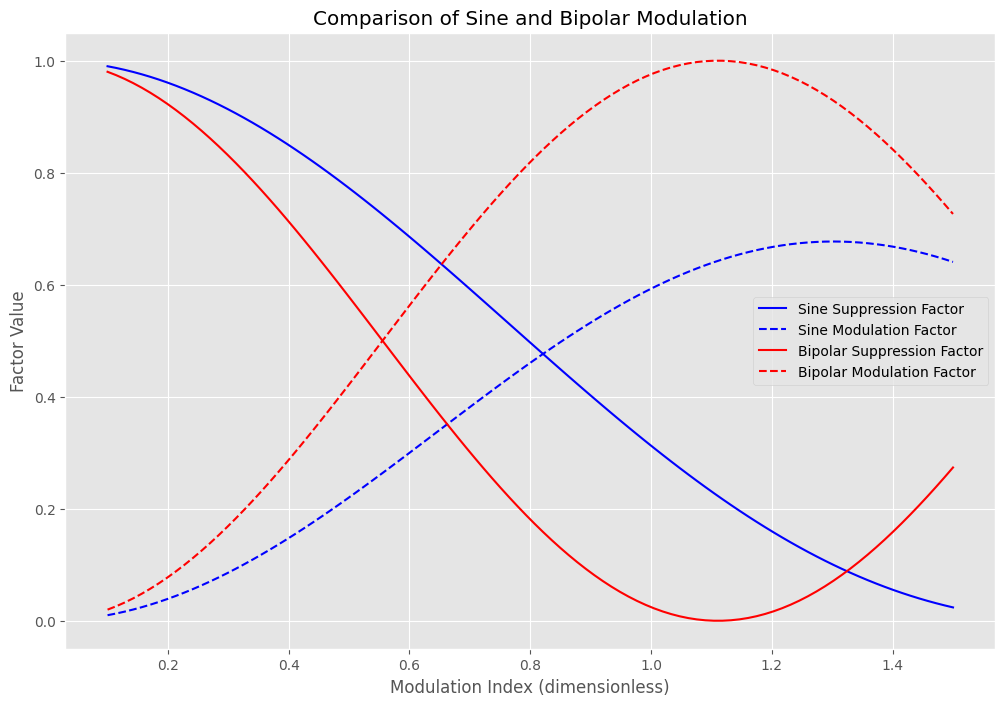

In [19]:
# Compare sine and bipolar modulation
mod_idx_values = np.linspace(0.1, 1.5, 100) * u.dimensionless

# Calculate suppression and modulation factors
sine_supp = [suppression_factor_sine(idx) for idx in mod_idx_values]
sine_mod = [modulation_factor_sine(idx) for idx in mod_idx_values]
bipolar_supp = [suppression_factor_bipolar(idx) for idx in mod_idx_values]
bipolar_mod = [modulation_factor_bipolar(idx) for idx in mod_idx_values]

plt.figure()
plt.plot(mod_idx_values.value, sine_supp, 'b-', label='Sine Suppression Factor')
plt.plot(mod_idx_values.value, sine_mod, 'b--', label='Sine Modulation Factor')
plt.plot(mod_idx_values.value, bipolar_supp, 'r-', label='Bipolar Suppression Factor')
plt.plot(mod_idx_values.value, bipolar_mod, 'r--', label='Bipolar Modulation Factor')
plt.xlabel('Modulation Index (dimensionless)')
plt.ylabel('Factor Value')
plt.title('Comparison of Sine and Bipolar Modulation')
plt.legend()
plt.grid(True)
plt.show()

## Power Distribution with Sine Modulation

Let's examine how power is distributed in a signal with sine modulation for both ranging and data.

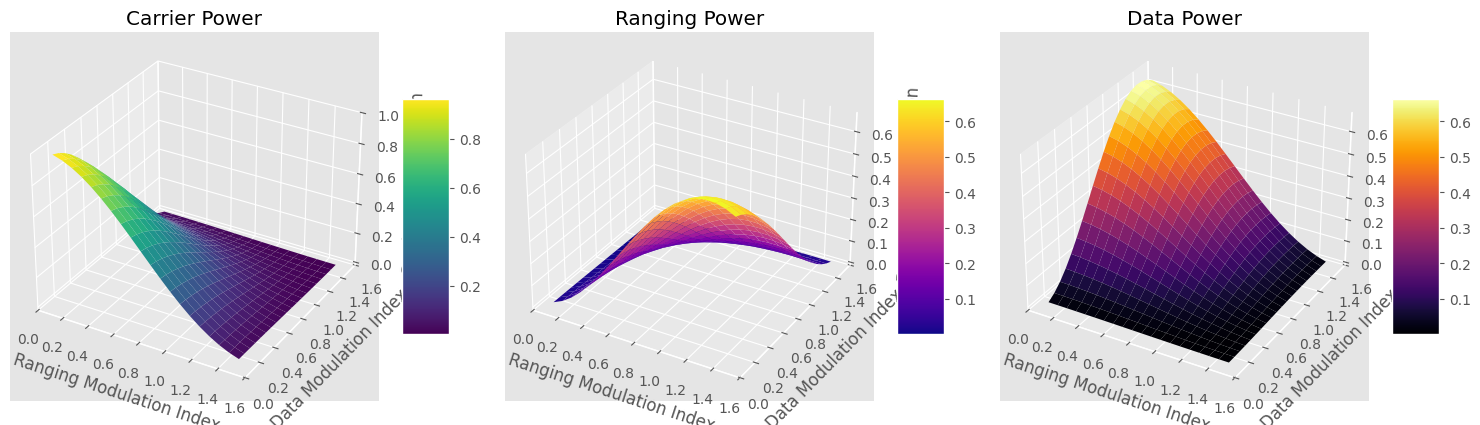

In [20]:
# Calculate power fractions with sine modulation
mod_idx_r_values = np.linspace(0.1, 1.5, 20) * u.dimensionless
mod_idx_data_values = np.linspace(0.1, 1.5, 20) * u.dimensionless

# Create meshgrid for 3D plotting
R, D = np.meshgrid(mod_idx_r_values.value, mod_idx_data_values.value)
carrier_power = np.zeros_like(R)
ranging_power = np.zeros_like(R)
data_power = np.zeros_like(R)

# Calculate power fractions for each combination
for i, mod_idx_r in enumerate(mod_idx_r_values):
    for j, mod_idx_data in enumerate(mod_idx_data_values):
        carrier, ranging, data = power_fractions_sine(mod_idx_r, mod_idx_data)
        carrier_power[j, i] = carrier
        ranging_power[j, i] = ranging
        data_power[j, i] = data

# Plot carrier power distribution
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(R, D, carrier_power, cmap='viridis')
ax1.set_xlabel('Ranging Modulation Index')
ax1.set_ylabel('Data Modulation Index')
ax1.set_zlabel('Carrier Power Fraction')
ax1.set_title('Carrier Power')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(R, D, ranging_power, cmap='plasma')
ax2.set_xlabel('Ranging Modulation Index')
ax2.set_ylabel('Data Modulation Index')
ax2.set_zlabel('Ranging Power Fraction')
ax2.set_title('Ranging Power')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(R, D, data_power, cmap='inferno')
ax3.set_xlabel('Ranging Modulation Index')
ax3.set_ylabel('Data Modulation Index')
ax3.set_zlabel('Data Power Fraction')
ax3.set_title('Data Power')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

## Practical Example: CCSDS PN Ranging

Let's work through a practical example of a CCSDS PN ranging system.

In [21]:
# CCSDS PN ranging example
sequence_length = 1009470  # Standard CCSDS sequence length
chip_rate = 1.0 * u.MHz  # 1 MHz chip rate
mod_idx_r = 0.8 * u.dimensionless  # Ranging modulation index
mod_idx_cmd = 0.5 * u.dimensionless  # Command modulation index
prn0 = 50 * u.dBHz  # PR/N0 value

# Calculate range ambiguity
ambiguity = pn_sequence_range_ambiguity(sequence_length, chip_rate)
print(f"Range ambiguity: {ambiguity.to(u.km):.2f}")

# Calculate chip SNR
snr = chip_snr(chip_rate, prn0)
print(f"Chip SNR: {snr:.2f}")

# Calculate power fractions with sine modulation
carrier, ranging, data = power_fractions_sine(mod_idx_r, mod_idx_cmd)
print(f"Power fractions (sine modulation):")
print(f"  Carrier: {carrier:.4f} ({10*np.log10(carrier):.2f} dB)")
print(f"  Ranging: {ranging:.4f} ({10*np.log10(ranging):.2f} dB)")
print(f"  Data:    {data:.4f} ({10*np.log10(data):.2f} dB)")
print(f"  Sum:     {carrier + ranging + data:.4f}")

Range ambiguity: 75657.87 km
Chip SNR: -10.00 dB
Power fractions (sine modulation):
  Carrier: 0.3836 (-4.16 dB)
  Ranging: 0.3557 (-4.49 dB)
  Data:    0.1094 (-9.61 dB)
  Sum:     0.8487
